<h1 align=center><font size = 5>ConvNeXt</h1 >

<h3>Objective for this Notebook</h3>
<h5> 1. 觀看架構圖，試著撰寫出模型</h5>
<hr>

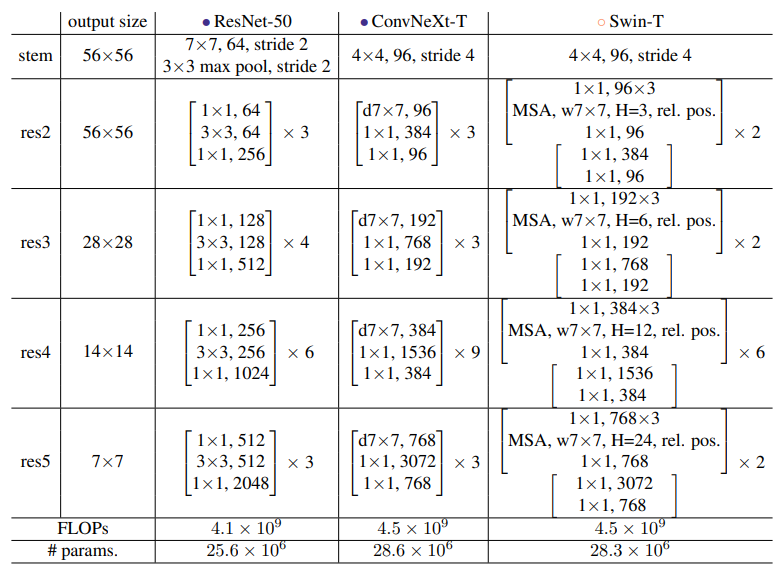 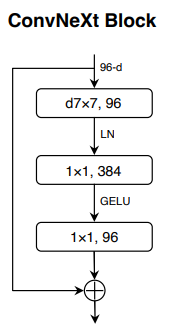

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from prometheus_client.decorator import append

In [27]:
#移除DropPath、gamma、scale、init_weight等設定，專注於框架

class Block(nn.Module):

    def __init__(self, dim):
        super().__init__()
        # depthwise conv

        # pointwise/1x1 convs, implemented with linear layers


    def forward(self, x):

        #x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)




        #x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)


        return x

class ConvNeXt(nn.Module):

    def __init__(self, in_chans=3, num_classes=1000,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768]
                 ):
        super().__init__()





        self.head = nn.Linear(dims[-1], num_classes)

    def forward_features(self, x):

        return # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):

        return x

#作者提供的LN
class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

# 雙擊展開正確答案

<!--


#移除DropPath、gamma、scale、init_weight等設定，專注於框架

class Block(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)


    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + x
        return x

class ConvNeXt(nn.Module):

    def __init__(self, in_chans=3, num_classes=1000,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768]
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i]) for j in range(depths[i])]
            )
            self.stages.append(stage)

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

-->